Сбор сырых данных #этот кусок не запускала тк не собераем

In [ ]:
import dwhimpalautil

class ImpalaConnection:

    def __init__(self):
        self.conn = dwhimpalautil.getImpalaConnect()
        self.cursor = self.conn.cursor()
        self.res = None

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.cursor.close()
        self.conn.close()
        
    def exec_sql(self, sql, is_res_needed=False):
        self.cursor.execute(sql)
        if is_res_needed:
            self.res = self.cursor.fetchall()
            return self.res
        
class ETL(ImpalaConnection):
    
    def __init__(self):
        super().__init__()

    CREATE_SAMPLE_SQL = """
        create table if not exists usr_erin.churn_sample
        (
                user_id string
            ,   is_churned int
            ,   login_last_dt string
            ,   level int
            ,   donate_total float
        )
    """

    SAMPLE_DATA_SQL = """
        with levels as
        (
            select snap_dt
                ,  cast(user_id as string) as user_id
                ,  max(level) as level
            from game_profiles
            where snap_dt >= '{churned_start_date}'
                and snap_dt < '{churned_end_date}'
            group by snap_dt, user_id
        )
        ,   churned_profiles as
        (
            select a.user_id
                ,  to_date(login_last_ts) as login_last_dt
                ,  1 as is_churned
            from global_profiles 
            where project_id = 1234
                and login_last_ts >= '{churned_start_date}'
                and login_last_ts < '{churned_end_date}'
        )
        ,   not_churned_profiles as
        (
            select user_id
                ,  to_date(date_add('{churned_start_date}', 
                           round((datediff('{churned_end_date}','{churned_start_date}')-1)*rand()))) as login_last_dt
                ,  0 as is_churned 
            from oda_onelink.profiles
            where project_id = 1234
                and login_first_ts < date_sub(cast(unix_timestamp('{churned_start_date}') as timestamp), 30)
                and login_last_ts > date_add(cast(unix_timestamp('{churned_end_date}') as timestamp), 30)
        )
        ,   united as
        (
            select user_id, is_churned, login_last_dt
            from churned_profiles
            union all
            select user_id, is_churned, login_last_dt
            from not_churned_profiles
        )
        ,   payments_total as
        (
            select a.user_id, coalesce(sum(b.pay_amt), 0) as donate_total
            from united a 
                left join payments b
                on (a.user_id = cast(b.global_user_id as string) and a.login_last_dt >= b.log_dt)
            where b.log_dt < '{churned_end_date}'
                and b.project_id in (10,20,30)
            group by a.user_id
        )
        
        insert into usr_erin.churn_sample
        
        select a.user_id
            ,  a.is_churned
            ,  a.login_last_dt
            ,  cast(b.level as int) as level
            ,  c.donate_total
        from united a
            join levels b
            on (a.user_id = b.user_id and a.login_last_dt = b.snap_dt)
            join payments_total c
            on a.user_id = c.user_id
        where level >= {min_level}
            and level <= {max_level}
    """

    CREATE_PROFILES_SQL = """
        create table if not exists usr_erin.churn_profiles 
        (
                user_id string
            ,   age int
            ,   gender string
            ,   reg_country_name string
            ,   days_between_reg_fl int
            ,   days_between_fl_effreg int
            ,   days_between_fl_df int
            ,   has_return_date int
            ,   has_phone_number int
        )
    """

    PROFILES_DATA_SQL = """
        with profiles_data as
        (
            select  a.user_id
                ,   register_ts
                ,   login_first_ts
                ,   return_ts
                ,   donate_first_ts
            from gloabl_profiles a 
                join usr_erin.churn_sample b
                on a.user_id = cast(b.user_id as string)
            where project_id = 1234
        )
        ,   soc_data_raw as
        (
            select  cast(csaid as string) as user_id
                ,   from_unixtime(unix_timestamp(swa_dob ,'yyyyMMdd'), 'yyyy-MM-dd') as birth_date
                ,   swa_gender as gender
                ,   swa_phone as phone
                ,   rank() over (partition by csaid order by created desc) as level
            from soc_data  a 
                join usr_erin.churn_sample b
                on cast(a.csaid as string) = b.user_id
        )
        ,   soc_data as
        (
            select user_id
                ,  birth_date
                ,  gender
                ,  phone
            from soc_data_raw
            where level = 1
        )
        
        insert into usr_erin.churn_profiles
        
        select  a.user_id as user_id
            ,   cast(floor(datediff(now(), birth_date) / 365) as int) as age
            ,   gender
            ,   reg_country_name
            ,   coalesce(datediff(login_first_ts, register_ts), -1) as days_between_reg_fl
            ,   coalesce(datediff(donate_first_ts, login_first_ts), -1) as days_between_fl_df
            ,   if(return_ts is not null, 1, 0) as has_return_date
            ,   if(phone='', 0, 1) as has_phone_number
        from profiles_data a
            left join soc_data b
            on a.user_id = b.user_id
    """
    CREATE_PAYMENTS_SQL = """
        create table if not exists usr_erin.churn_payments
        (
                log_dt string
            ,   user_id string
            ,   pay_amt float
            ,   trans_amt int
        )
    """
    # ........
    CREATE_REPORTS_SQL = """
        create table if not exists usr_erin.churn_reports
        (
                log_dt string
            ,   user_id string
            ,   reports_amt int
        )
    """
    # ........
    CREATE_ABUSERS_SQL = """
        create table if not exists usr_erin.churn_abusers
        (
                log_dt string
            ,   user_id string
            ,   sess_with_abusers_amt int
        )
    """
    # ........
    CREATE_LOGINS_SQL = """
        create table if not exists usr_erin.churn_logins
        (
                log_dt string
            ,   user_id string
            ,   disconnect_amt int
            ,   session_amt int
        )
    """
    # ........
    CREATE_PINGS_SQL = """
        create table if not exists usr_erin.churn_pings
        (
                log_dt string
            ,   user_id string
            ,   avg_min_ping float
        )
    """
    # ........
    CREATE_SESSIONS_SQL = """
        create table if not exists usr_erin.churn_sessions
        (
                log_dt string
            ,   user_id string
            ,   kd float
            ,   win_rate float
            ,   leavings_rate float
            ,   session_player float
        )
    """
    
    # ........
    CREATE_SHOP_SQL = """
        create table if not exists usr_erin.churn_shop
        (
                log_dt string
            ,   user_id string
            ,   silver_spent string
            ,   gold_spent int
        )
    """
    # ........
    
    TRUNCATE_RAW_DATA_SQL = """
        truncate table {}
    """
    
    CHECK_SQL = """
        select count(*) as cnt, count(distinct user_id) as users
        from {tbl_name}
    """
    
    def create_table(self, sql, is_res_needed=False):
        self.exec_sql(sql, is_res_needed=is_res_needed)
    
    def insert_table(self, sql, is_res_needed=False, **kwargs):
        self.exec_sql(sql.format(**kwargs), is_res_needed=is_res_needed)

Создание датасета #не запускаю, собирала датасеты ровно по этому коду и все получилось

In [ ]:
def build_dataset_raw(churned_start_date='2019-01-01', 
                      churned_end_date='2019-02-01', 
                      inter_list=[(1,7),(8,14)],
                      raw_data_path='train/',
                      dataset_path='dataset/', 
                      mode='train'):
    
    start_t = time.time()
 
    sample = pd.read_csv('{}sample.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    profiles = pd.read_csv('{}profiles.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    payments = pd.read_csv('{}payments.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    reports = pd.read_csv('{}reports.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    abusers = pd.read_csv('{}abusers.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    logins = pd.read_csv('{}logins.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    pings = pd.read_csv('{}pings.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    sessions = pd.read_csv('{}sessions.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    shop = pd.read_csv('{}shop.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    
    print('Run time (reading csv files): {}'.format(time_format(time.time()-start_t)))    
#-----------------------------------------------------------------------------------------------------    
    print('NO dealing with outliers, missing values and categorical features...')
#-----------------------------------------------------------------------------------------------------        
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом
    
    print('Creating dataset...')
    # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
    if mode == 'train':
        dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
    elif mode == 'test':
        dataset = sample.copy()[['user_id', 'level', 'donate_total']]

    # Пройдемся по всем источникам, содержащим "динамичекие" данные
    for df in [payments, reports, abusers, logins, pings, sessions, shop]:

        # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
        data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
        data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - 
                                data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.days)
        df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

        # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
        features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
        print('Processing with features:', features)
        for feature in features:
            for i, inter in enumerate(inter_list):
                inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)].\
                                groupby('user_id')[feature].mean().reset_index().\
                                rename(index=str, columns={feature: feature+'_{}'.format(i+1)})
                df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

        # Добавляем построенные признаки в датасет
        dataset = pd.merge(dataset, df_features, how='left', on='user_id')
        
        print('Run time (calculating features): {}'.format(time_format(time.time()-start_t)))

    # Добавляем "статические" признаки
    dataset = pd.merge(dataset, profiles, on='user_id')
#---------------------------------------------------------------------------------------------------------------------------
    dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', index=False)
    print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'.\
          format(dataset_path, time_format(time.time()-start_t)))

In [ ]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [ ]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='train/',
                  dataset_path='dataset/', 
                  mode='train')

In [ ]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='test/',
                  dataset_path='dataset/', 
                  mode='test')

Обработка данных #так же не гружу, после выложу датасеты после всех обработок

In [ ]:
def prepare_dataset(dataset, 
                    dataset_type='train',
                    dataset_path='dataset/'):
    print(dataset_type)
    start_t = time.time()
    print('Dealing with missing values, outliers, categorical features...')
    
    # Профили
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['gender'] = dataset['gender'].fillna(dataset['gender'].mode()[0])
    dataset.loc[~dataset['gender'].isin(['M', 'F']), 'gender'] = dataset['gender'].mode()[0]
    dataset['gender'] = dataset['gender'].map({'M': 1., 'F':0.})
    dataset.loc[(dataset['age'] > 80) | (dataset['age'] < 7), 'age'] = round(dataset['age'].median())
    dataset.loc[dataset['days_between_fl_df'] < -1, 'days_between_fl_df'] = -1
    # Пинги
    for period in range(1,len(INTER_LIST)+1):
        col = 'avg_min_ping_{}'.format(period)
        dataset.loc[(dataset[col] < 0) | 
                    (dataset[col].isnull()), col] = dataset.loc[dataset[col] >= 0][col].median()
    # Сессии и прочее
    dataset.fillna(0, inplace=True)
    dataset.to_csv('{}dataset_{}.csv'.format(dataset_path, dataset_type), sep=';', index=False)
         
    print('Dataset is successfully prepared and saved to {}, run time (dealing with bad values): {}'.\
          format(dataset_path, time_format(time.time()-start_t))) 

In [ ]:
prepare_dataset(dataset=train, dataset_type='train')
prepare_dataset(dataset=test, dataset_type='test')

In [59]:
import pandas as pd

In [60]:
#загружаю датасеты обработанные вышеуказанным кодом
train = pd.read_csv('dataset/dataset_train.csv', sep=';')
test = pd.read_csv('dataset/dataset_test.csv', sep=';')

In [61]:
print(train.shape, test.shape)

(469475, 62) (44764, 61)


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469475 entries, 0 to 469474
Data columns (total 62 columns):
user_id                    469475 non-null object
is_churned                 469475 non-null int64
level                      469475 non-null int64
donate_total               469475 non-null float64
pay_amt_1                  469475 non-null float64
pay_amt_2                  469475 non-null float64
pay_amt_3                  469475 non-null float64
pay_amt_4                  469475 non-null float64
trans_amt_1                469475 non-null float64
trans_amt_2                469475 non-null float64
trans_amt_3                469475 non-null float64
trans_amt_4                469475 non-null float64
reports_amt_1              469475 non-null float64
reports_amt_2              469475 non-null float64
reports_amt_3              469475 non-null float64
reports_amt_4              469475 non-null float64
sess_with_abusers_amt_1    469475 non-null float64
sess_with_abusers_amt_2    

In [63]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix


In [64]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [65]:
#делим датасет на признаки и целевую, маштабируем и снижаем дисбаланс

In [66]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

Wall time: 27.9 s


Одбираем признаки, выбрала RFE тк лучше всего f1 

In [67]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50


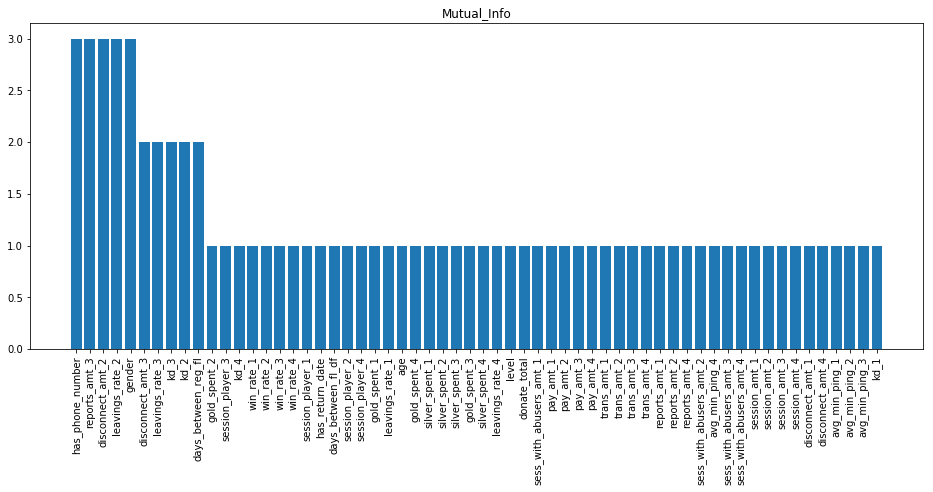

In [68]:
feature_importance = plot_importance(selector.ranking_, X.columns, 'Mutual_Info')

In [69]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

In [70]:
fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.2870936594785967
Recall: 0.43008678881388623
F1: 0.3443350704497201
Log Loss: 0.13594830805932462
ROC AUC: 0.8967121299934184


Обучение на XGB

In [71]:
%%time
param = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=-1,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

Wall time: 0 ns


In [74]:
model = param.fit(X_train_rfe, y_train_balanced)

In [75]:
predict_proba_test = model.predict_proba(X_test_rfe)
predict_test = model.predict(X_test_rfe)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2870936594785967
Recall: 0.43008678881388623
F1: 0.3443350704497201
Log Loss: 0.13594830805932462
ROC AUC: 0.8967121299934184


Загружаю тест, и вот тут начинается непонятное

In [99]:
df_test = pd.read_csv('dataset/dataset_test.csv', sep=';')

In [100]:
df_test.head()

,user_id,level,donate_total,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,trans_amt_1,trans_amt_2,trans_amt_3,...,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,0bda14606761d90210e6e5f7432b5a5c2f7cbda6d5144e...,13,11972.219727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,28.0,1.0,0,197,1,1
1,beaabc52f2f369d27d4b4132d6629e475f2117568a9041...,25,8000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,39.0,1.0,0,999,1,1
2,969daefac09c760c75e0a131d4397ef43278151ead9232...,12,5408.120117,500.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.666667,0.000000,0.000000,0.000000,17.0,1.0,0,22,1,1
3,2f8a302052389f20fbe09e144c60917e5495312f7a83bc...,49,121067.437500,450.0,600.0,0.0,0.0,1.0,1.0,0.0,...,1.428571,155.000000,0.000000,0.000000,23.0,0.0,0,131,1,1
4,10bf851621a8a69b0900f3b5f3c0904a45f2b952e6e2d4...,11,4194.000000,392.0,541.0,0.0,342.0,1.0,2.0,0.0,...,0.000000,168.571429,25.714286,101.714286,11.0,1.0,0,0,1,1


In [101]:
df_test.columns

Index(['user_id', 'level', 'donate_total', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3',
       'trans_amt_4', 'reports_amt_1', 'reports_amt_2', 'reports_amt_3',
       'reports_amt_4', 'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4', 'session_amt_1',
       'session_amt_2', 'session_amt_3', 'session_amt_4', 'disconnect_amt_1',
       'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4',
       'avg_min_ping_1', 'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4',
       'kd_1', 'kd_2', 'kd_3', 'kd_4', 'win_rate_1', 'win_rate_2',
       'win_rate_3', 'win_rate_4', 'session_player_1', 'session_player_2',
       'session_player_3', 'session_player_4', 'leavings_rate_1',
       'leavings_rate_2', 'leavings_rate_3', 'leavings_rate_4',
       'silver_spent_1', 'silver_spent_2', 'silver_spent_3', 'silver_spent_4',
       'gold_spent_1', 'gold_spent_2', 'gold_spen

In [102]:
feats = ['level', 'donate_total', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
       'reports_amt_1', 'reports_amt_2', 'reports_amt_4',
       'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4', 'session_amt_1',
       'session_amt_2', 'session_amt_3', 'session_amt_4', 'disconnect_amt_1',
       'disconnect_amt_4', 'avg_min_ping_1', 'avg_min_ping_2',
       'avg_min_ping_3', 'avg_min_ping_4', 'kd_1', 'kd_4', 'win_rate_1',
       'win_rate_2', 'win_rate_3', 'win_rate_4', 'session_player_1',
       'session_player_2', 'session_player_3', 'session_player_4',
       'leavings_rate_1', 'leavings_rate_4', 'silver_spent_1',
       'silver_spent_2', 'silver_spent_3', 'silver_spent_4', 'gold_spent_1',
       'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'age',
       'days_between_fl_df', 'has_return_date']

Загружены данные, выбраны фичи 

In [103]:
test = df_test.drop(columns=['user_id'])

In [104]:
df_test['is_churned'] = model.predict(test.loc[:, feats])


In [105]:
df_test.loc[:, ['user_id', 'is_churned']].to_csv('VKazakova_predictions.csv', index=False)

In [106]:
df_test[df_test['is_churned']>0]

,user_id,level,donate_total,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,trans_amt_1,trans_amt_2,trans_amt_3,...,gold_spent_2,gold_spent_3,gold_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number,is_churned
178,1a4fc98f35f48209ae99505824ddf11f0d1585a384151f...,27,15100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28.0,1.0,334,41,1,1,1
348,de53675679c3b61ecfd56657e12c9f89b95857a0f638b8...,22,114600.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,42.0,1.0,0,40,1,1,1
678,82700a8b8af03783b24128542c24748dae278291268fb9...,19,7359.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.0,1.0,0,128,1,0,1
718,37d4bc3a6c195ef0422a084d043fff982e7e85c71db148...,23,9852.320312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,43.0,1.0,0,548,1,0,1
869,aef91f1199a0e00ab12992a910e03ad937257a721f1689...,18,2144.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15.0,1.0,0,330,1,0,1
924,4cc03b22290d2138923a533e40752a32c1abe4e4210e80...,15,650.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,1.0,0,340,1,1,1
935,07d01677703a0c4e6b94bafdba82d08f663ddd7a1b195a...,41,177616.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.0,1.0,0,121,1,0,1
1065,8dec93282b1835e5d48f15afb435e1b22ff972b7df86e3...,13,24990.140625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.0,1.0,0,141,1,1,1
1305,47e0afcaaccd4a30393a893501d1444efd311fca23bcc0...,16,8180.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,1.0,0,40,1,0,1
1360,4d9f2d81462289610d474cf09e7309fea1e549dc285db3...,11,16224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19.0,1.0,0,87,1,1,1


 На тесте получается всего 284 ухода на 44764 наблюдения, очень мало. Раньше выходило еще меньше. Понимаю что скорее всего ошибка в том что не сделела что то с тестом, не отмаштабировала или не сбалансировала. Пробовла, но даже написать не выходит как

In [ ]:
#Если после
#test = df_test.drop(columns=['user_id'])
#Написать 
#test_mm = MinMaxScaler().fit_transform(test)
#и передать ее на предсказание
#df_test['is_churned'] = model.predict(test.loc[:, feats])
#выходит ошибка 'numpy.ndarray' object has no attribute 'loc
#c value тоже не выходит 
# про балансировку не заикаюсь, совсем тупик)

В общем понимаю что очень мало уходов, но что предпринять чтоб поправить ситуацию никак не соображу, i need help